### Попытка использовать нейронную сеть для задачи классификации


In [3]:
# ну конечно подключим pandas
import pandas as pd

# display() для удобства
from IPython.display import display

# есть категориальные данные - нужно будет кодировать
from sklearn.preprocessing import OrdinalEncoder

# задача классификации, пробуем нейронку, но нужны бейз-лайны для сравнения
    # модель классификации логистической регрессии
from sklearn.linear_model import LogisticRegression  

    # модель классификации случайного леса
from sklearn.ensemble import RandomForestClassifier

# ну и куда уж без бустинга и кросс-валидации
from sklearn.model_selection import RandomizedSearchCV

# не забудем про метрики моделей классификации
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

# что забыли? Правильно, метод для разделения выборки на тренировочную и валидационную
from sklearn.model_selection import train_test_split

# ну и на всякий случай для перемешивания при up/down-сэмплинге
from sklearn.utils import shuffle

In [4]:
df = pd.read_csv('drug200.csv')

In [5]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [6]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


Отлично. Пропусков нет, все данные нормального типа. Только текстовые.... Непорядок. Преобраазуем методом Ordinal Encoding, чтоб не создавать dummy переменные через One-hot-encoding. 

Для начала определимся, какие столбцы кодируем. А кодируем все текстовые столбцы, кроме target. Соберем все столбцы для кодироваания

In [8]:
columns_for_encoding = []
for i in range(0,df.shape[1]):
    if (df[df.columns[i]].dtype == 'object') and (df.columns[i] != 'Drug'):
        columns_for_encoding.append(df.columns[i])


Ну и закодируем.

In [9]:
df_ordinal = df.copy()
encoder = OrdinalEncoder()

df_ordinal[columns_for_encoding] = pd.DataFrame(encoder.fit_transform(df[columns_for_encoding]), columns=columns_for_encoding)


df_ordinal.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0.0,0.0,0.0,25.355,DrugY
1,47,1.0,1.0,0.0,13.093,drugC
2,47,1.0,1.0,0.0,10.114,drugC
3,28,0.0,2.0,0.0,7.798,drugX
4,61,0.0,1.0,0.0,18.043,DrugY


Собственно... закодировали. Разделим, обучим и посмотрим на первый бейз-лайн

In [10]:
target = df_ordinal['Drug']
features = df_ordinal.drop('Drug', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=12345)



Тут я попробовал классификацию случайным лесом... так я узнал, что: 
- классификация в sklearn бинарна. Необходимо либо сводить к задаче бинарной классификации, либо использовать kNN, нейронку или что-то еще;
- мультиклассовая и мультилейбольна классификация это разные вещи. Первая - когда существует больше 2х классов и наличие одного исключает наличие другого, например классификация фруктов: яблоко, банан, апельсин, томат (ага, в Китае это фрукт). Вторая - когда одному набору фич может принадлежать больше 1 класса, например сладкий и желты, кислый и желтый, круглый и красный;
- У catboost есть возможность мультиклассовой классификации.

Собственно последнее и используем. Будем делать с кросс-валидацией (данные - на вес золота), ну а параметры будем подбирать поиском по сетке (впринципе можно и через randomized_search, он быстрее, но этот текст писался когда уже получили результат :)).

In [11]:
from catboost import Pool, CatBoostClassifier, cv

cv_dataset = Pool(data=features_train,
                  label=target_train,
                  cat_features=None)




params = {"loss_function": "MultiClass"}

scores = cv(cv_dataset,
            params,
            fold_count=3, 
            plot=False,
            as_pandas=True)




model_catboost = CatBoostClassifier()

grid = {'max_depth':range(1,16,4),
        'learning_rate':[0.1, 0.5, 1],
        'iterations':range(1,13,3)
       }

grid_search_result = model_catboost.grid_search(grid, 
                                       X=cv_dataset,
                                       cv=3,
                                       plot=False)

0:	learn: 1.5805355	test: 1.5863882	best: 1.5863882 (0)	total: 94.7ms	remaining: 1m 34s
1:	learn: 1.5568893	test: 1.5669474	best: 1.5669474 (1)	total: 116ms	remaining: 57.9s
2:	learn: 1.5342010	test: 1.5467640	best: 1.5467640 (2)	total: 138ms	remaining: 46s
3:	learn: 1.5017494	test: 1.5179834	best: 1.5179834 (3)	total: 405ms	remaining: 1m 40s
4:	learn: 1.4702757	test: 1.4899425	best: 1.4899425 (4)	total: 420ms	remaining: 1m 23s
5:	learn: 1.4362563	test: 1.4601814	best: 1.4601814 (5)	total: 436ms	remaining: 1m 12s
6:	learn: 1.4099631	test: 1.4360617	best: 1.4360617 (6)	total: 453ms	remaining: 1m 4s
7:	learn: 1.3813949	test: 1.4098549	best: 1.4098549 (7)	total: 469ms	remaining: 58.2s
8:	learn: 1.3654720	test: 1.3985812	best: 1.3985812 (8)	total: 487ms	remaining: 53.6s
9:	learn: 1.3319859	test: 1.3671308	best: 1.3671308 (9)	total: 503ms	remaining: 49.8s
10:	learn: 1.3076955	test: 1.3455122	best: 1.3455122 (10)	total: 575ms	remaining: 51.7s
11:	learn: 1.2781985	test: 1.3156240	best: 1.3156

95:	learn: 0.4211048	test: 0.5159305	best: 0.5159305 (95)	total: 2.57s	remaining: 24.2s
96:	learn: 0.4172984	test: 0.5125964	best: 0.5125964 (96)	total: 2.6s	remaining: 24.2s
97:	learn: 0.4130848	test: 0.5087809	best: 0.5087809 (97)	total: 2.61s	remaining: 24s
98:	learn: 0.4090492	test: 0.5043954	best: 0.5043954 (98)	total: 2.63s	remaining: 23.9s
99:	learn: 0.4051607	test: 0.5006768	best: 0.5006768 (99)	total: 2.65s	remaining: 23.8s
100:	learn: 0.4021289	test: 0.4978855	best: 0.4978855 (100)	total: 2.66s	remaining: 23.7s
101:	learn: 0.3980949	test: 0.4944064	best: 0.4944064 (101)	total: 2.75s	remaining: 24.2s
102:	learn: 0.3946518	test: 0.4914263	best: 0.4914263 (102)	total: 2.8s	remaining: 24.4s
103:	learn: 0.3899007	test: 0.4864522	best: 0.4864522 (103)	total: 2.82s	remaining: 24.3s
104:	learn: 0.3857986	test: 0.4820520	best: 0.4820520 (104)	total: 2.83s	remaining: 24.2s
105:	learn: 0.3815736	test: 0.4776700	best: 0.4776700 (105)	total: 2.85s	remaining: 24s
106:	learn: 0.3785355	test

189:	learn: 0.1937510	test: 0.2871135	best: 0.2871135 (189)	total: 4.77s	remaining: 20.3s
190:	learn: 0.1922567	test: 0.2854002	best: 0.2854002 (190)	total: 4.78s	remaining: 20.3s
191:	learn: 0.1908263	test: 0.2838026	best: 0.2838026 (191)	total: 4.8s	remaining: 20.2s
192:	learn: 0.1895263	test: 0.2823584	best: 0.2823584 (192)	total: 4.82s	remaining: 20.1s
193:	learn: 0.1880696	test: 0.2805174	best: 0.2805174 (193)	total: 4.83s	remaining: 20.1s
194:	learn: 0.1865924	test: 0.2788182	best: 0.2788182 (194)	total: 4.84s	remaining: 20s
195:	learn: 0.1854033	test: 0.2775332	best: 0.2775332 (195)	total: 4.86s	remaining: 19.9s
196:	learn: 0.1841241	test: 0.2760457	best: 0.2760457 (196)	total: 4.94s	remaining: 20.1s
197:	learn: 0.1830422	test: 0.2749621	best: 0.2749621 (197)	total: 4.97s	remaining: 20.1s
198:	learn: 0.1819392	test: 0.2738056	best: 0.2738056 (198)	total: 4.99s	remaining: 20.1s
199:	learn: 0.1807052	test: 0.2724363	best: 0.2724363 (199)	total: 5.03s	remaining: 20.1s
200:	learn: 0

281:	learn: 0.1144078	test: 0.1988319	best: 0.1988319 (281)	total: 6.66s	remaining: 17s
282:	learn: 0.1138844	test: 0.1982525	best: 0.1982525 (282)	total: 6.7s	remaining: 17s
283:	learn: 0.1133323	test: 0.1976087	best: 0.1976087 (283)	total: 6.72s	remaining: 16.9s
284:	learn: 0.1127806	test: 0.1968880	best: 0.1968880 (284)	total: 6.74s	remaining: 16.9s
285:	learn: 0.1122806	test: 0.1962952	best: 0.1962952 (285)	total: 6.75s	remaining: 16.9s
286:	learn: 0.1117445	test: 0.1956214	best: 0.1956214 (286)	total: 6.77s	remaining: 16.8s
287:	learn: 0.1112166	test: 0.1949319	best: 0.1949319 (287)	total: 6.79s	remaining: 16.8s
288:	learn: 0.1106794	test: 0.1943157	best: 0.1943157 (288)	total: 6.81s	remaining: 16.7s
289:	learn: 0.1101972	test: 0.1938283	best: 0.1938283 (289)	total: 6.82s	remaining: 16.7s
290:	learn: 0.1096759	test: 0.1932068	best: 0.1932068 (290)	total: 6.84s	remaining: 16.7s
291:	learn: 0.1091367	test: 0.1925463	best: 0.1925463 (291)	total: 6.86s	remaining: 16.6s
292:	learn: 0.1

377:	learn: 0.0776792	test: 0.1543484	best: 0.1543484 (377)	total: 10.6s	remaining: 17.5s
378:	learn: 0.0774123	test: 0.1540385	best: 0.1540385 (378)	total: 10.6s	remaining: 17.4s
379:	learn: 0.0771690	test: 0.1537485	best: 0.1537485 (379)	total: 10.7s	remaining: 17.4s
380:	learn: 0.0768731	test: 0.1534124	best: 0.1534124 (380)	total: 10.7s	remaining: 17.4s
381:	learn: 0.0766268	test: 0.1531295	best: 0.1531295 (381)	total: 10.7s	remaining: 17.3s
382:	learn: 0.0763565	test: 0.1527604	best: 0.1527604 (382)	total: 10.7s	remaining: 17.3s
383:	learn: 0.0760770	test: 0.1523733	best: 0.1523733 (383)	total: 10.8s	remaining: 17.3s
384:	learn: 0.0758182	test: 0.1520654	best: 0.1520654 (384)	total: 10.8s	remaining: 17.2s
385:	learn: 0.0755696	test: 0.1517725	best: 0.1517725 (385)	total: 10.8s	remaining: 17.2s
386:	learn: 0.0752727	test: 0.1513788	best: 0.1513788 (386)	total: 10.8s	remaining: 17.1s
387:	learn: 0.0750240	test: 0.1510665	best: 0.1510665 (387)	total: 10.8s	remaining: 17.1s
388:	learn

476:	learn: 0.0576528	test: 0.1287893	best: 0.1287893 (476)	total: 13.2s	remaining: 14.4s
477:	learn: 0.0575214	test: 0.1286225	best: 0.1286225 (477)	total: 13.2s	remaining: 14.4s
478:	learn: 0.0573800	test: 0.1284208	best: 0.1284208 (478)	total: 13.3s	remaining: 14.4s
479:	learn: 0.0572280	test: 0.1282150	best: 0.1282150 (479)	total: 13.3s	remaining: 14.4s
480:	learn: 0.0570818	test: 0.1280201	best: 0.1280201 (480)	total: 13.3s	remaining: 14.4s
481:	learn: 0.0569344	test: 0.1278074	best: 0.1278074 (481)	total: 13.3s	remaining: 14.3s
482:	learn: 0.0567864	test: 0.1275879	best: 0.1275879 (482)	total: 13.4s	remaining: 14.3s
483:	learn: 0.0566260	test: 0.1273893	best: 0.1273893 (483)	total: 13.4s	remaining: 14.3s
484:	learn: 0.0564851	test: 0.1272024	best: 0.1272024 (484)	total: 13.5s	remaining: 14.3s
485:	learn: 0.0563372	test: 0.1269858	best: 0.1269858 (485)	total: 13.5s	remaining: 14.3s
486:	learn: 0.0561810	test: 0.1267736	best: 0.1267736 (486)	total: 13.6s	remaining: 14.3s
487:	learn

578:	learn: 0.0455468	test: 0.1126777	best: 0.1126777 (578)	total: 15.8s	remaining: 11.5s
579:	learn: 0.0454509	test: 0.1125566	best: 0.1125566 (579)	total: 15.8s	remaining: 11.4s
580:	learn: 0.0453503	test: 0.1124112	best: 0.1124112 (580)	total: 15.8s	remaining: 11.4s
581:	learn: 0.0452678	test: 0.1123115	best: 0.1123115 (581)	total: 15.8s	remaining: 11.4s
582:	learn: 0.0451816	test: 0.1121970	best: 0.1121970 (582)	total: 15.9s	remaining: 11.3s
583:	learn: 0.0450890	test: 0.1120732	best: 0.1120732 (583)	total: 15.9s	remaining: 11.3s
584:	learn: 0.0449974	test: 0.1119587	best: 0.1119587 (584)	total: 15.9s	remaining: 11.3s
585:	learn: 0.0448964	test: 0.1118411	best: 0.1118411 (585)	total: 15.9s	remaining: 11.2s
586:	learn: 0.0447985	test: 0.1116961	best: 0.1116961 (586)	total: 15.9s	remaining: 11.2s
587:	learn: 0.0447120	test: 0.1115974	best: 0.1115974 (587)	total: 15.9s	remaining: 11.2s
588:	learn: 0.0446231	test: 0.1114784	best: 0.1114784 (588)	total: 16s	remaining: 11.1s
589:	learn: 

670:	learn: 0.0380863	test: 0.1023432	best: 0.1023432 (670)	total: 19.2s	remaining: 9.42s
671:	learn: 0.0380169	test: 0.1022423	best: 0.1022423 (671)	total: 19.2s	remaining: 9.39s
672:	learn: 0.0379480	test: 0.1021506	best: 0.1021506 (672)	total: 19.3s	remaining: 9.35s
673:	learn: 0.0378754	test: 0.1020523	best: 0.1020523 (673)	total: 19.3s	remaining: 9.32s
674:	learn: 0.0378087	test: 0.1019615	best: 0.1019615 (674)	total: 19.3s	remaining: 9.29s
675:	learn: 0.0377448	test: 0.1018654	best: 0.1018654 (675)	total: 19.3s	remaining: 9.26s
676:	learn: 0.0376785	test: 0.1017715	best: 0.1017715 (676)	total: 19.3s	remaining: 9.23s
677:	learn: 0.0376066	test: 0.1016716	best: 0.1016716 (677)	total: 19.4s	remaining: 9.2s
678:	learn: 0.0375415	test: 0.1015779	best: 0.1015779 (678)	total: 19.4s	remaining: 9.16s
679:	learn: 0.0374797	test: 0.1014902	best: 0.1014902 (679)	total: 19.4s	remaining: 9.13s
680:	learn: 0.0374138	test: 0.1014018	best: 0.1014018 (680)	total: 19.4s	remaining: 9.1s
681:	learn: 

765:	learn: 0.0325661	test: 0.0945580	best: 0.0945580 (765)	total: 21.9s	remaining: 6.68s
766:	learn: 0.0325198	test: 0.0944947	best: 0.0944947 (766)	total: 21.9s	remaining: 6.65s
767:	learn: 0.0324715	test: 0.0944226	best: 0.0944226 (767)	total: 21.9s	remaining: 6.62s
768:	learn: 0.0324231	test: 0.0943507	best: 0.0943507 (768)	total: 21.9s	remaining: 6.59s
769:	learn: 0.0323805	test: 0.0942954	best: 0.0942954 (769)	total: 22s	remaining: 6.58s
770:	learn: 0.0323352	test: 0.0942369	best: 0.0942369 (770)	total: 22.1s	remaining: 6.55s
771:	learn: 0.0322868	test: 0.0941670	best: 0.0941670 (771)	total: 22.1s	remaining: 6.52s
772:	learn: 0.0322268	test: 0.0940464	best: 0.0940464 (772)	total: 22.1s	remaining: 6.49s
773:	learn: 0.0321843	test: 0.0939795	best: 0.0939795 (773)	total: 22.1s	remaining: 6.46s
774:	learn: 0.0321346	test: 0.0939037	best: 0.0939037 (774)	total: 22.1s	remaining: 6.43s
775:	learn: 0.0320862	test: 0.0938290	best: 0.0938290 (775)	total: 22.2s	remaining: 6.4s
776:	learn: 0

866:	learn: 0.0281667	test: 0.0881307	best: 0.0881307 (866)	total: 23.7s	remaining: 3.64s
867:	learn: 0.0281299	test: 0.0880768	best: 0.0880768 (867)	total: 23.8s	remaining: 3.61s
868:	learn: 0.0280967	test: 0.0880258	best: 0.0880258 (868)	total: 23.8s	remaining: 3.58s
869:	learn: 0.0280589	test: 0.0879661	best: 0.0879661 (869)	total: 23.8s	remaining: 3.55s
870:	learn: 0.0280166	test: 0.0878858	best: 0.0878858 (870)	total: 23.8s	remaining: 3.53s
871:	learn: 0.0279792	test: 0.0878248	best: 0.0878248 (871)	total: 23.8s	remaining: 3.5s
872:	learn: 0.0279451	test: 0.0877692	best: 0.0877692 (872)	total: 23.8s	remaining: 3.47s
873:	learn: 0.0279055	test: 0.0877016	best: 0.0877016 (873)	total: 23.9s	remaining: 3.44s
874:	learn: 0.0278695	test: 0.0876487	best: 0.0876487 (874)	total: 23.9s	remaining: 3.41s
875:	learn: 0.0278349	test: 0.0875964	best: 0.0875964 (875)	total: 23.9s	remaining: 3.38s
876:	learn: 0.0277982	test: 0.0875526	best: 0.0875526 (876)	total: 23.9s	remaining: 3.35s
877:	learn:

959:	learn: 0.0250551	test: 0.0835372	best: 0.0835372 (959)	total: 25.6s	remaining: 1.07s
960:	learn: 0.0250257	test: 0.0834951	best: 0.0834951 (960)	total: 25.6s	remaining: 1.04s
961:	learn: 0.0249941	test: 0.0834490	best: 0.0834490 (961)	total: 25.7s	remaining: 1.01s
962:	learn: 0.0249688	test: 0.0834092	best: 0.0834092 (962)	total: 25.7s	remaining: 986ms
963:	learn: 0.0249438	test: 0.0833697	best: 0.0833697 (963)	total: 25.7s	remaining: 960ms
964:	learn: 0.0249119	test: 0.0833176	best: 0.0833176 (964)	total: 25.7s	remaining: 933ms
965:	learn: 0.0248849	test: 0.0832668	best: 0.0832668 (965)	total: 25.7s	remaining: 906ms
966:	learn: 0.0248546	test: 0.0832297	best: 0.0832297 (966)	total: 25.7s	remaining: 879ms
967:	learn: 0.0248261	test: 0.0831883	best: 0.0831883 (967)	total: 25.8s	remaining: 852ms
968:	learn: 0.0247964	test: 0.0831443	best: 0.0831443 (968)	total: 25.8s	remaining: 825ms
969:	learn: 0.0247672	test: 0.0831034	best: 0.0831034 (969)	total: 25.8s	remaining: 798ms
970:	learn


bestTest = 0.9626243715
bestIteration = 9

45:	loss: 0.9626244	best: 0.1728375 (35)	total: 645ms	remaining: 28ms

bestTest = 0.3342257936
bestIteration = 9

46:	loss: 0.3342258	best: 0.1728375 (35)	total: 824ms	remaining: 17.5ms

bestTest = 0.1796263275
bestIteration = 9

47:	loss: 0.1796263	best: 0.1728375 (35)	total: 905ms	remaining: 0us
Estimating final quality...


In [12]:
depth_catboost = grid_search_result['params']['depth']
iterations_catboost = grid_search_result['params']['iterations']
learning_rate_catboost = grid_search_result['params']['learning_rate']

model = CatBoostClassifier(depth = depth_catboost,
                          iterations = iterations_catboost,
                          learning_rate = learning_rate_catboost
                          )

model.fit(features_train, target_train)

predictions_catboost = model.predict(features_valid) 

from sklearn.metrics import accuracy_score

print('accuracy:',accuracy_score(target_valid, predictions_catboost))

0:	learn: 0.7408775	total: 1.49ms	remaining: 13.4ms
1:	learn: 0.4588053	total: 4.47ms	remaining: 17.9ms
2:	learn: 0.3313561	total: 7.45ms	remaining: 17.4ms
3:	learn: 0.2476626	total: 13.4ms	remaining: 20.1ms
4:	learn: 0.1995392	total: 24.6ms	remaining: 24.6ms
5:	learn: 0.1445670	total: 26.6ms	remaining: 17.7ms
6:	learn: 0.1202779	total: 32.3ms	remaining: 13.8ms
7:	learn: 0.1062970	total: 42.8ms	remaining: 10.7ms
8:	learn: 0.0946738	total: 52.5ms	remaining: 5.83ms
9:	learn: 0.0858618	total: 70ms	remaining: 0us
accuracy: 0.95


Стоп. Это все классно, а классы то у нас сбалансированны?

<AxesSubplot:>

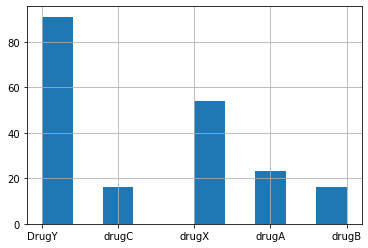

In [13]:
df['Drug'].hist()

А классы то не сбалансированы.

Самое время поразмыслить над задачей: нам необходимо определить, какой тип наркотика был употреблен. В зависимости от вида - может быть разное лечение последствий, цена ошибки велика, поэтому один accuracy, даже высокий - не достаточен. Следует смотреть еще и на точность Precision (TP/(TP+FP)). С другой стороны, цена нераспознания какого-то вида тоже велика, поэтому следует смотреть на полноту Recall (TP/(TP+FN)). 

Но.... если нам надо и Precision и Recall - следует использовать F1


In [14]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

print('precision:',precision_score(target_valid, predictions_catboost, average = 'weighted'))
print('recall:',recall_score(target_valid, predictions_catboost, average = 'weighted'))
print('f1:',f1_score(target_valid, predictions_catboost, average = 'weighted'))

precision: 0.975
recall: 0.95
f1: 0.9541666666666666


Ну в целом, с учетом дисбаланса классов - результаты очень даже. Тут прям вопрос-вопрос, а нужна ли нейронка и сможем ли сделать лучше.

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


encoder = OrdinalEncoder()

df_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

target = df_ordinal['Drug']
features = df_ordinal.drop('Drug', axis=1)

display(df_ordinal.head())


Using TensorFlow backend.
/Users/q/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/q/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/q/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/q/opt/anaconda3/lib/python3.7/site-packages/tenso

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,8.0,0.0,0.0,0.0,167.0,0.0
1,30.0,1.0,1.0,0.0,89.0,3.0
2,30.0,1.0,1.0,0.0,43.0,3.0
3,12.0,0.0,2.0,0.0,10.0,4.0
4,44.0,0.0,1.0,0.0,133.0,0.0


Построим модель в которой будет 8 входных нейронов и 5 независимых признаков. На выходе мы должны получить 5 классов. И прогоним 200 эпох с батчем в 5 строк через кросс-валидацию. В качестве функции потерь будем использовать кросс-энтропию.

In [31]:
def baseline_model():
 
    model = Sequential()

    model.add(Dense(256, input_dim=5, activation='relu'))
    model.add(Dense(69, activation='relu'))
    model.add(Dense(19, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, features, target, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 89.50% (9.86%)


Такое себе. Классификатор точнее accura-тнее чем нейронка. Будем пробовать улучшать нейронку. Ну и надо научиться декодировать результаты из числовой интерпритации OHE в текстовую, как было изначально/

In [36]:
results

array([1.        , 1.        , 0.85000002, 1.        , 0.69999999,
       0.80000001, 0.94999999, 0.80000001, 0.89999998, 0.94999999])